##### 5_allAprDrgModel

This notebook takes the csv that was compiled from the notebook 4_featureEngineering

In [36]:
import os
import json

import numpy as np
import pandas as pd

import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import export_graphviz

from matplotlib import pyplot as plt
%matplotlib inline

##### Data Prep

In [2]:
dataFol = os.getcwd() + "/dataFiles/"

In [3]:
top10df = pd.read_csv(dataFol + 'top10AprHospFeat.csv')

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
l1 = len(top10df)
top10df.shape

(2209446, 68)

In [5]:
top10df.drop(['Unnamed: 0',
              'APR DRG Code', 
              'Efficient use of medical imaging national comparison', # too many NaNs
              'number_of_interns_and',
              'geometry', #removing spatial columns
              'lonlat',
              'lat',
              'long',
              'puma',
              'Provider ID', # already have facility id
              'rural_versus_urban_R', # already have rural_versus_urban_U
              'Total Costs', # related to charges
              'ratioChargesCosts',
              'chargesPerDay', 
              'ratioSumChargesPerFacPerYrToBedDays',
              'sumChargesPerFacIdPerYr',
              'Length of Stay', # object and same as days
              'totalFertile', # does not seem to be important to DRGs not related to birth
              'ratioFertilityTotalPopulation'], axis=1, inplace=True)

In [6]:
top10df.dropna(inplace=True)

In [7]:
l2 = len(top10df)
top10df.shape

(2133701, 49)

In [8]:
print('lost ', str((l1-l2)/l1*100), '% of data') 

lost  3.428234951204963 % of data


Separate out the categorical like variables from the numerical variables to normalize

In [9]:
top10df.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['Health Service Area', 'Facility Id', 'APR DRG Description',
       'APR Severity of Illness Code', 'Total Charges', 'yr',
       'Hospital overall rating', 'Mortality national comparison',
       'Safety of care national comparison', 'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison', 'fte_employees_on_payroll',
       'number_of_beds', 'totalPopulation', 'totalInsured',
       'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr', 'ratioDrgToFacility',
       'payment_Medicare', 'payment_Blue Cross/Blue Shield',
       'payment_Private Health Insurance', 'payment_Self-Pay',
       'payment_Medicaid', 'payment_Federal/State/Local/VA',
       'payment_Miscellaneous/Other', 'payment_Department of Corrections',
       'payment_Managed Care, Unspecified', 'numberOfPaymentTypes',
       'Type of Admission_Elective', 'Ty

In [10]:
cols_to_scale = ['fte_employees_on_payroll', 'number_of_beds',
                 'totalPopulation', 'totalInsured',
                 'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr',
                 'ratioDrgToFacility', 'numberOfPaymentTypes',
                 'numberUrgentAdmits', 'ratioInsuredTotalPopulation',
                 'days', 'avgNumberDays']

In [11]:
for cols in range(len(cols_to_scale)):
    top10df[str('scale_'+cols_to_scale[cols])] = preprocessing.scale(top10df[cols_to_scale[cols]])

/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/nfshome/yg833/.conda/envs/mgPUI/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [12]:
top10df = pd.get_dummies(top10df, columns=['Health Service Area', 'APR DRG Description', 'Facility Id'])

In [13]:
top10df.shape

(2133701, 190)

##### Train Test Split for PCA, LDA, OLS

In [14]:
x_val = top10df.drop(['Total Charges', # drop variables not to be used in the feature set
                      'fte_employees_on_payroll', 'number_of_beds', 'totalPopulation', #these were scaled so no need to use it again
                      'totalInsured',
                      'countPerDrgPerFacIdPerYr',
                      'countPerFacIdPerYr',
                      'ratioDrgToFacility',
                      'numberOfPaymentTypes',
                      'numberUrgentAdmits',
                      'ratioInsuredTotalPopulation',
                      'days', 'avgNumberDays'], axis=1)

In [15]:
x_val.shape

(2133701, 177)

In [16]:
top10df['scaledCharges'] = preprocessing.scale(np.log(top10df['Total Charges']))

In [17]:
y_val = top10df['scaledCharges']

In [18]:
y_val.shape

(2133701,)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(x_val, y_val, test_size=0.33, random_state=13)

##### Multivariate Linear Regression

##### statsmodels for the summary table

In [20]:
x_train = sm.add_constant(X_train)
model = sm.OLS(y_train, x_train)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          scaledCharges   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                 4.849e+04
Date:                Thu, 09 May 2019   Prob (F-statistic):               0.00
Time:                        23:34:43   Log-Likelihood:            -7.5746e+05
No. Observations:             1429579   AIC:                         1.515e+06
Df Residuals:                 1429433   BIC:                         1.517e+06
Df Model:                         145                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------

##### scikit learn api

In [21]:
clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.8310494000714138
0.831334939475077


##### Principal Component Analysis

In [22]:
pca = PCA().fit(x_val)

Text(0.5, 1.0, 'Top 10 Charges Explained Variance')

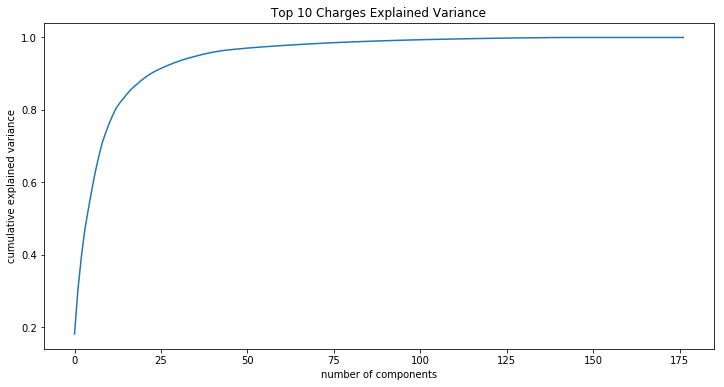

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Top 10 Charges Explained Variance')

In [24]:
pca = PCA(n_components=50)
pca.fit(x_val)

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [25]:
print(pca.components_)

[[-1.12999410e-01 -1.35725408e-02  1.04547161e-01 ... -2.12670184e-03
   3.36335670e-04  3.28262246e-03]
 [ 3.23250029e-01  5.01731759e-03 -1.53985102e-01 ...  1.28956226e-03
  -2.72528662e-04  3.31689410e-03]
 [-1.32896239e-01 -7.76236767e-03 -4.90203756e-01 ...  7.26292063e-03
   1.46490551e-02  6.55910427e-03]
 ...
 [-2.58638163e-02  1.80563808e-03  3.22184730e-02 ... -5.03482796e-02
  -5.96283532e-03  1.02126141e-01]
 [ 3.84488765e-03 -5.95341968e-04  1.55690171e-02 ...  3.42358655e-02
   3.50210404e-02 -5.97840239e-02]
 [-2.65207195e-02  4.76394926e-04  6.13241349e-03 ...  1.45300135e-03
   7.72966141e-02 -9.71933478e-02]]


In [26]:
print(pca.explained_variance_)

[4.05119862 2.77199439 2.04167443 1.66806557 1.25206061 1.18347821
 1.11171462 0.94382483 0.85562482 0.62647302 0.5758716  0.48874715
 0.45214493 0.31042497 0.27175528 0.26142204 0.24722537 0.21248693
 0.18895114 0.18379814 0.16968185 0.15402616 0.13814121 0.1259285
 0.10644649 0.10251663 0.09719968 0.09131262 0.08769628 0.08344805
 0.07745725 0.07431521 0.06681863 0.06076956 0.05903305 0.05698103
 0.05674545 0.05583115 0.04771722 0.0465757  0.04273054 0.03610291
 0.03559796 0.03011252 0.02613569 0.02293461 0.02232678 0.02133854
 0.02039597 0.01973344]


In [27]:
x_val_transformed = pca.fit_transform(x_val)

##### Running Linear Regression Again Using the dimensionally reduced dataset

In [28]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(x_val_transformed, y_val, test_size=0.33, random_state=13)

In [29]:
clf = LinearRegression()
clf.fit(X_train_pca, y_train_pca)
y_pred = clf.predict(X_test_pca)
print(clf.score(X_train_pca, y_train_pca))
print(clf.score(X_test_pca, y_test_pca))

0.8016447737023423
0.8018434798446163


##### Decision Tree

In [30]:
# learn model
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

# in sample accuracy
print('In sample accuracy:',dt.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:',dt.score(X_test, y_test))

In sample accuracy: 0.969794990842705
Out of sample accuracy: 0.9274661512399454


In [31]:
# get the average OS accuracy for a range of tree depth
OS=[]
for i in range(1, 25):
    dt = DecisionTreeRegressor(max_depth=i)
    dt.fit(X_train, y_train)
    OS.append(dt.score(X_test, y_test))
print(np.mean(OS), OS)

0.8454164049858442 [0.35963874711701116, 0.569592839785839, 0.6484066529925803, 0.7080330006714739, 0.7566463129213475, 0.796073639413641, 0.8259489210543188, 0.8536293034401489, 0.8744237209103055, 0.8904259029649784, 0.9031070568527285, 0.9122135591733808, 0.9190705348705885, 0.9252464726213703, 0.9300345793198308, 0.9332923055261524, 0.9353238134213506, 0.9361589433437418, 0.9365434446500778, 0.9362656809088171, 0.9360862388274382, 0.9354594165204175, 0.9348493287982903, 0.9335233035544307]


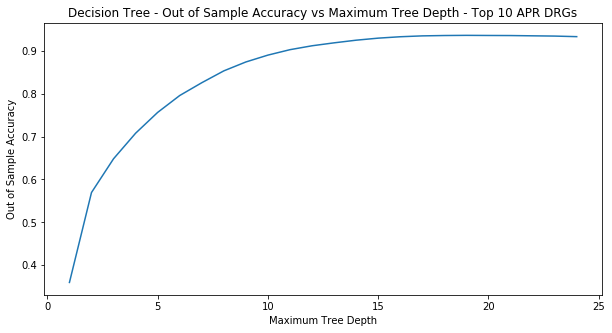

<Figure size 432x288 with 0 Axes>

In [32]:
# your code here
plt.figure(figsize=(10, 5))
plt.plot(range(1, 25), OS)
plt.xlabel("Maximum Tree Depth")
plt.ylabel("Out of Sample Accuracy")
plt.title("Decision Tree - Out of Sample Accuracy vs Maximum Tree Depth - Top 10 APR DRGs")
plt.show()
plt.savefig('decisionTreeTop10APRDRGsOutOfSampleAccuracy.png')

In [33]:
# learn model
dt = DecisionTreeRegressor(max_depth=15)
dt.fit(X_train, y_train)

# in sample accuracy
print('In sample accuracy:',dt.score(X_train, y_train))

# out of sample accuracy
print('Out of sample accuracy:',dt.score(X_test, y_test))

In sample accuracy: 0.935525915652812
Out of sample accuracy: 0.9300934511377891


##### Decision Tree Visualization

In [37]:
thestring=tree.export_graphviz(dt, out_file=None,
                               feature_names=X_train.columns.values,  
                               class_names=dt.classes_,  
                               filled=True, rounded=True,  
                               special_characters=True,impurity=False).replace("<br/>",", ").replace("&le;","<=").replace("=<","=\"").replace(">,","\",")
print(thestring)

NameError: name 'tree' is not defined